<a href="https://colab.research.google.com/github/chloe-mt-cheng/imf_css/blob/main/alf_inputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys
sys.path.append('/content/gdrive/My Drive')

**Data files if you need them**


*   B058 blue coadded spectrum: https://drive.google.com/file/d/1PjUxRuOCIIiZknhQA3ubLnYStqDGaE4y/view?usp=sharing
*   B058 red coadded spectrum: https://drive.google.com/file/d/1vNOZLFeNbtF9EKMI5LXZeEBFvEpZxPek/view?usp=sharing
*Telluric grid: https://drive.google.com/file/d/10eJfwxxFE1BNvRpYGqVwQjo34Wi4zNeD/view?usp=sharing



In [4]:
!pip install astro-sedpy
!pip install astro-prospector

     |████████████████████████████████| 1.8MB 2.8MB/s 
     |████████████████████████████████| 143kB 2.9MB/s 


In [14]:
import numpy as np
import astropy.io.fits as fits
import astropy.io.ascii
from astropy.convolution import interpolate_replace_nans, Gaussian1DKernel, convolve, convolve_fft
import telluric_correction as tell
from sedpy.observate import air2vac
from prospect import utils
from scipy.interpolate import interp1d
import scipy.optimize as op
from scipy.stats import chisquare
from read_alf import Alf
import sys
import glob
import pandas as pd
import matplotlib.pyplot as plt

font = {'family':'serif',
        'weight':'normal',
        'size':20
}
plt.rc('font',**font)

%matplotlib inline

import warnings
warnings.filterwarnings('ignore') #Polyfit spits out a bunch of warnings (RankWarning: Polyfit may be poorly conditioned), use this to suppress

In [15]:
#Get PypeIt-reduced spectra
blue_path = '/content/gdrive/My Drive/B058_blue_coadd1d.fits'
b058_blue = fits.open(blue_path)
blue_header = b058_blue[0].header
blue_dat = b058_blue[1].data
b058_blue.close()

red_path = '/content/gdrive/My Drive/B058_red_coadd1d.fits'
b058_red = fits.open(red_path)
red_header = b058_red[0].header
red_dat = b058_red[1].data
b058_red.close()

blue_wave = blue_dat['wave']
red_wave = red_dat['wave']
blue_flux = blue_dat['flux']
red_flux = red_dat['flux']
total_wave = np.concatenate((blue_wave, red_wave))
total_flux = np.concatenate((blue_flux, red_flux))

In [16]:
#Telluric correction functions
def telluric_correction(blue_path, red_path, template_wave, template_flux):
    """Return the tellurically-corrected flux and corresponding wavelength for a reduced object.

    Parameters
    ----------
    blue_path : str
        Path to the blue coadded spectrum
    red_path : str
        Path to the red coadded spectrum

    Returns
    -------
    total_target_wave : tuple
        Wavelength array
    telluric_corrected_flux : tuple
        Tellurically-corrected flux array
    """

    #Import co-added target spectra
    blue_coadd1d = fits.open(blue_path)
    blue_dat = blue_coadd1d[1].data
    blue_coadd1d.close()

    red_coadd1d = fits.open(red_path)
    red_dat = red_coadd1d[1].data
    red_coadd1d.close()

    #Get wavelengths and fluxes for target and template
    target_blue_wave = blue_dat['wave']
    target_red_wave = red_dat['wave']
    target_blue_flux = blue_dat['flux']
    target_red_flux = red_dat['flux']
    target_blue_ivar = blue_dat['ivar']
    target_red_ivar = red_dat['ivar']
    target_noise = 1/np.sqrt(np.concatenate((target_blue_ivar, target_red_ivar)))

    template_blue_wave = template_wave[(template_wave >= np.min(target_blue_wave)) & (template_wave <= np.max(target_blue_wave))]
    template_red_wave = template_wave[(template_wave >= np.min(target_red_wave)) & (template_wave <= np.max(target_red_wave))]
    template_blue_flux = template_flux[(template_wave >= np.min(target_blue_wave)) & (template_wave <= np.max(target_blue_wave))]
    template_red_flux = template_flux[(template_wave >= np.min(target_red_wave)) & (template_wave <= np.max(target_red_wave))]

    #Get resolution using wavelength ranges from target object
    resb_template, resr_template = tell.lris_res(template_blue_wave, template_red_wave)

    #Concatenate into one wavelength range
    total_template_res = np.concatenate((resb_template, resr_template))
    total_template_wave = np.concatenate((template_blue_wave, template_red_wave))
    total_template_flux = np.concatenate((template_blue_flux, template_red_flux))
    total_target_wave = np.concatenate((target_blue_wave, target_red_wave))
    total_target_flux = np.concatenate((target_blue_flux, target_red_flux))

    #Convert telluric resolution to km/s
    c = 299792.458 #speed of light
    R = 20000 #instrument resolution
    inval = total_template_wave/R
    in_sigma = inval/2.*np.sqrt(2.*np.log(2))
    in_sigma_kms = (in_sigma/total_template_wave)*c

    #Smooth template spectrum
    sigma_aa_desired = total_template_res/c*total_template_wave
    sigma_aa_original = in_sigma_kms/c*total_template_wave
    delta_sigma_aa_vector = np.sqrt(sigma_aa_desired**2 - sigma_aa_original**2)
    smoothed_template_flux = utils.smoothing.smoothspec(total_template_wave, total_template_flux, outwave=total_template_wave, smoothtype='lsf', resolution=delta_sigma_aa_vector, fftsmooth=True)

    #Re-grid template spectrum by interpolating onto target wavelength grid
    regrid_template_flux = np.interp(total_target_wave, total_template_wave, smoothed_template_flux)

    #Normalize the target and template spectra over 9250-9650A
    normrange_wave = total_target_wave[(total_target_wave >= 9250) & (total_target_wave <= 9650)]
    normrange_target_flux = total_target_flux[(total_target_wave >= 9250) & (total_target_wave <= 9650)]
    normrange_template_flux = regrid_template_flux[(total_target_wave >= 9250) & (total_target_wave <= 9650)]
    normed_template_flux = tell.normalize(normrange_wave, normrange_template_flux)
    normed_target_flux = tell.normalize(normrange_wave, normrange_target_flux)

    #Do the minimization over 9320-9380A
    correction_wave = normrange_wave[(normrange_wave >= 9320) & (normrange_wave <= 9380)]
    correction_template_flux = normed_template_flux[(normrange_wave >= 9320) & (normrange_wave <= 9380)]
    correction_target_flux = normed_target_flux[(normrange_wave >= 9320) & (normrange_wave <= 9380)]

    x0 = 1 #Initial guess
    res = op.minimize(tell.minimization, x0, args=(correction_template_flux, correction_target_flux), method='Nelder-Mead', tol=1e-6)
    #print(res)

    #Get the chi-squared value for the fit
    corrected_template_flux = tell.Tf(res.x, correction_template_flux)
    residuals = ((correction_target_flux - corrected_template_flux)/correction_target_flux)*100
    cdist = np.sort(residuals)
    chisq_val, p_val = chisquare(cdist)

    #Scale the template spectrum by the best-fit scale factor 
    scaled_template_flux = tell.Tf(res.x, regrid_template_flux)

    return total_target_wave, scaled_template_flux, chisq_val, total_target_flux

def best_template(blue_path, red_path, template_wave, template_fluxes):
    """Loop through whole telluric grid and return best tellurically-corrected spectrum.

    Parameters
    ----------
    blue_path : str
      Path to blue coadded spectrum
    red_path : str
      Path to red coadded spectrum
    template_wave : tuple
      Wavelength for template spectra
    template_fluxes : tuple
      All template fluxes
    
    Returns
    -------
    best_scaled_template : tuple
      The best-fitting, scaled template spectrum
    tell_flux : tuple
      Tellurically-corrected flux
    tell_wave : tuple
      Wavelength array
    """

    #Loop through all spectra in the grid and use them to tellurically correct the data
    scaled_dat = []
    for i in range(len(template_fluxes)):
        for j in range(len(template_fluxes[i])):
            for k in range(len(template_fluxes[i][j])):
                for l in range(len(template_fluxes[i][j][k])):
                    scaled_dat.append(telluric_correction(blue_path, red_path, template_wave, 
                                                          template_fluxes[i][j][k][l]))
    scaled_dat = np.array(scaled_dat)
    scaled_wave = scaled_dat[:,0]
    scaled_flux = scaled_dat[:,1]
    chisquares = scaled_dat[:,2]
    target_flux = scaled_dat[:,3]
    
    #Pick the template with the smallest chisquare value and use it to tellurically-correct the spectrum
    best_scaled_template = scaled_flux[np.argmin(chisquares)]
    tell_flux = target_flux[np.argmin(chisquares)]/best_scaled_template
    tell_wave = scaled_wave[np.argmin(chisquares)] #This doesn't really matter, wavelength array stays the same throughout

    return best_scaled_template, tell_flux, tell_wave

#Tellurically-correct new spectra
def telluric_correction_routine(blue_path, red_path):
    """Return final tellurically-corrected spectrum.  Essentially just executes the two functions above.

    Parameters
    ----------
    blue_path : str
      Path to blue coadded spectrum
    red_path : stra
      Path to red coadded spectrum
    
    Returns
    -------
    tell_flux : tuple
      Tellurically-corrected flux
    tell_wave : tuple
      Wavelength array
    scaled_template : tuple
      Best-fitting, scaled template spectrum.  For testing.
    """

    #Import telluric grid
    file = '/content/gdrive/My Drive/TelFit_MaunaKea_3100_26100_R20000.fits'
    hdul = fits.open(file)
    header0 = hdul[0].header
    data0 = hdul[0].data #flux
    header1 = hdul[1].header
    data1 = hdul[1].data #wavelength
    hdul.close()
    template_wave = data1*10 #Convert from nm to A
    template_fluxes = data0
                    
    #Scale the template spectra
    scaled_template, tell_flux, tell_wave = best_template(blue_path, red_path, template_wave, template_fluxes)
    
    return tell_flux, tell_wave, scaled_template

In [17]:
#Tellurically-correct reduced spectra - this will take a few minutes to run
tell_flux, tell_wave, scaled_template = telluric_correction_routine(blue_path, red_path)

In [19]:
#Continuum-normalization code I wrote awhile back
def data_ranges(lambda_min, lambda_max, flux, wavelength):
    """Return the data within the desired wavelength range.
    
    Parameters
    ----------
    lambda_min : float
        The lower bound of the wavelength range
    lambda_max : float
        The upper bound of the wavelength range
    flux : tuple
        The flux data
    wavelength: tuple
        The wavelength data
        
    Returns
    -------
    wavelength_inrange : tuple
        The wavelength data within the desired wavelength range
    flux_inrange : tuple
        The flux data within the desired wavelength range
    """
    
    rng = (wavelength >= lambda_min) & (wavelength <= lambda_max)
    wavelength_inrange = wavelength[rng]
    flux_inrange = flux[rng]
    return wavelength_inrange, flux_inrange

def poly_order(lambda_min, lambda_max):
    """Return the order of the polynomial by which to continuum-normalize the spectrum.
    
    Parameters
    ----------
    lambda_min : float
        The lower bound of the wavelength range
    lambda_max : float
        The upper bound of the wavelength range
        
    Returns
    -------
    (lambda_min/lambda_max)/100 : int
        The order of the polynomial by which to continuum-normalize the spectrum
    """
    
    return int((lambda_max - lambda_min)/100)

def continuum_normalize(lambda_min, lambda_max, flux, wavelength):
    """Return the spectrum normalized by the fitted polynomial shape of the continuum.
    
    Parameters
    ----------
    lambda_min : float
        The lower bound of the wavelength range
    lambda_max : float
        The upper bound of the wavelength range
    flux : tuple
        The flux data
    wavelength: tuple
        The wavelength data
        
    Returns
    -------
    wavelength_inrange : tuple
        The wavelength data within the desired wavelength range
    flux_norm : tuple
        The continuum-normalized flux within the desired wavelength range
    """
    
    #Get the data in the desired wavelength range
    wavelength_inrange, flux_inrange = data_ranges(lambda_min, lambda_max, flux, wavelength)
    
    #Get the order of the polynomial 
    n = poly_order(lambda_min, lambda_max)
    
    #Fit an nth-order polynomial to the spectrum
    xrange = np.linspace(np.min(lambda_min), np.max(lambda_max), len(wavelength_inrange))
    polynomial_fit = np.polyfit(xrange, flux_inrange, n)
    poly_obj = np.poly1d(polynomial_fit)
    
    #Divide out the fitted polynomial to get a continuum-normalized spectrum
    flux_norm = flux_inrange/poly_obj(xrange)
    return wavelength_inrange, flux_norm

Text(0.5, 0, 'Wavelength ($\\AA$)')

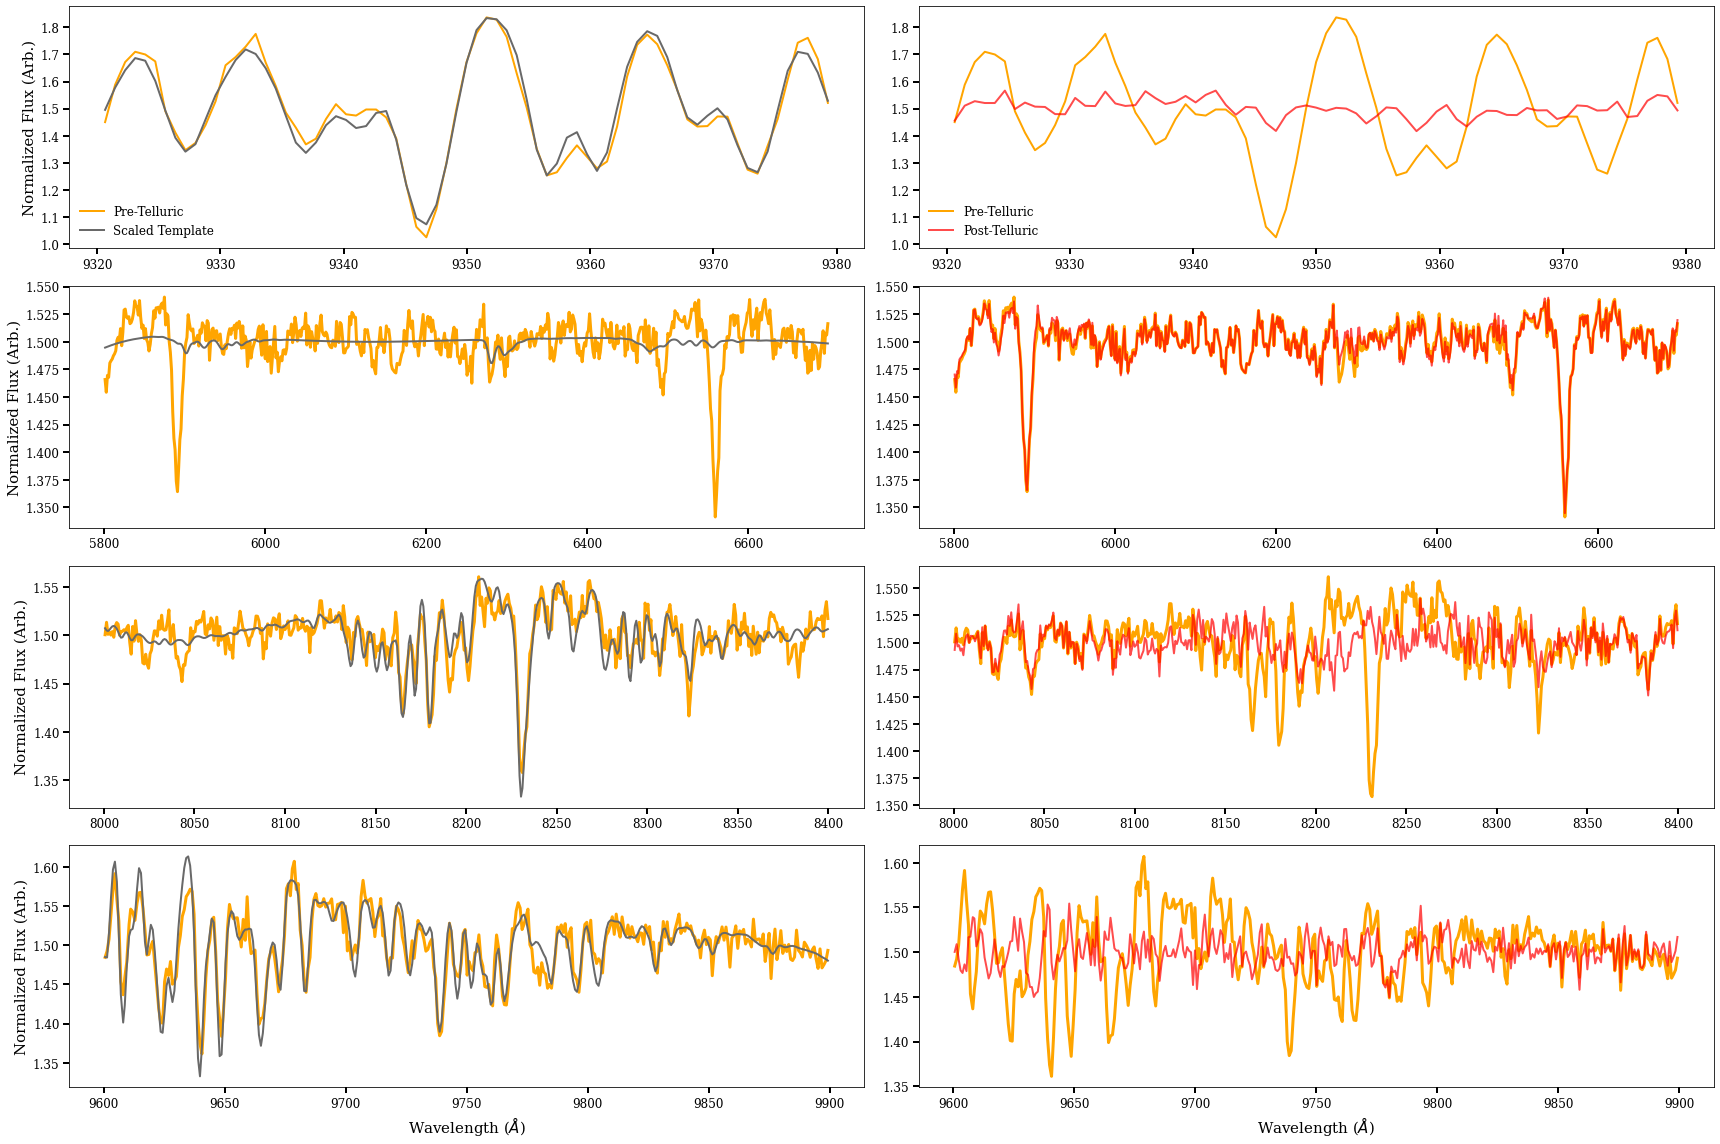

In [21]:
#Check telluric corrections 
feature_6300_range = [5800, 6700]
feature_8200_range = [8000, 8400]
feature_9700_range = [9600, 9900]
correction_range = [9320, 9380]

#Pre-telluric correction
norm_wave_total_correction, norm_flux_total_correction = continuum_normalize(correction_range[0], correction_range[-1], total_flux, total_wave)
norm_wave_total_6300, norm_flux_total_6300 = continuum_normalize(feature_6300_range[0], feature_6300_range[-1], total_flux, total_wave)
norm_wave_total_8200, norm_flux_total_8200 = continuum_normalize(feature_8200_range[0], feature_8200_range[-1], total_flux, total_wave)
norm_wave_total_9700, norm_flux_total_9700 = continuum_normalize(feature_9700_range[0], feature_9700_range[-1], total_flux, total_wave)

#Post-telluric correction
norm_wave_tell_correction, norm_flux_tell_correction = continuum_normalize(correction_range[0], correction_range[-1], tell_flux, tell_wave)
norm_wave_tell_6300, norm_flux_tell_6300 = continuum_normalize(feature_6300_range[0], feature_6300_range[-1], tell_flux, tell_wave)
norm_wave_tell_8200, norm_flux_tell_8200 = continuum_normalize(feature_8200_range[0],  feature_8200_range[-1], tell_flux, tell_wave)
norm_wave_tell_9700, norm_flux_tell_9700 = continuum_normalize(feature_9700_range[0],  feature_9700_range[-1], tell_flux, tell_wave)

#Scaled template
norm_wave_scale_correction, norm_flux_scale_correction = continuum_normalize(correction_range[0], correction_range[-1], scaled_template, tell_wave)
norm_wave_scale_6300, norm_flux_scale_6300 = continuum_normalize(feature_6300_range[0], feature_6300_range[-1], scaled_template, tell_wave)
norm_wave_scale_8200, norm_flux_scale_8200 = continuum_normalize(feature_8200_range[0], feature_8200_range[-1], scaled_template, tell_wave)
norm_wave_scale_9700, norm_flux_scale_9700 = continuum_normalize(feature_9700_range[0], feature_9700_range[-1], scaled_template, tell_wave)

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(24, 16))
fig.set_tight_layout(True)
ax[0,0].plot(norm_wave_total_correction, norm_flux_total_correction+0.5, color='orange', lw=2, label='Pre-Telluric')
ax[0,0].plot(norm_wave_scale_correction, norm_flux_scale_correction+0.5, color='dimgrey', lw=2, label='Scaled Template')
ax[0,0].tick_params(length=6, width=2, labelsize=12)
ax[0,0].set_ylabel('Normalized Flux (Arb.)', fontsize=15)
ax[0,0].legend(fontsize=12, framealpha=0)

ax[1,0].plot(norm_wave_total_6300, norm_flux_total_6300+0.5, color='orange', lw=3)
ax[1,0].plot(norm_wave_scale_6300, norm_flux_scale_6300+0.5, color='dimgrey', lw=2)
ax[1,0].tick_params(length=6, width=2, labelsize=12)
ax[1,0].set_ylabel('Normalized Flux (Arb.)', fontsize=15)

ax[2,0].plot(norm_wave_total_8200, norm_flux_total_8200+0.5, color='orange', lw=3)
ax[2,0].plot(norm_wave_scale_8200, norm_flux_scale_8200+0.5, color='dimgrey', lw=2)
ax[2,0].tick_params(length=6, width=2, labelsize=12)
ax[2,0].set_ylabel('Normalized Flux (Arb.)', fontsize=15)

ax[3,0].plot(norm_wave_total_9700, norm_flux_total_9700+0.5, color='orange', lw=3)
ax[3,0].plot(norm_wave_scale_9700, norm_flux_scale_9700+0.5, color='dimgrey', lw=2)
ax[3,0].tick_params(length=6, width=2, labelsize=12)
ax[3,0].set_ylabel('Normalized Flux (Arb.)', fontsize=15)
ax[3,0].set_xlabel('Wavelength ($\AA$)', fontsize=15)

ax[0,1].plot(norm_wave_total_correction, norm_flux_total_correction+0.5, color='orange', lw=2, label='Pre-Telluric')
ax[0,1].plot(norm_wave_tell_correction, norm_flux_tell_correction+0.5, color='r', alpha=0.7, lw=2, label='Post-Telluric')
ax[0,1].tick_params(length=6, width=2, labelsize=12)
ax[0,1].legend(fontsize=12, framealpha=0)

ax[1,1].plot(norm_wave_total_6300, norm_flux_total_6300+0.5, color='orange', lw=3)
ax[1,1].plot(norm_wave_tell_6300, norm_flux_tell_6300+0.5, color='r', alpha=0.7, lw=2)
ax[1,1].tick_params(length=6, width=2, labelsize=12)

ax[2,1].plot(norm_wave_total_8200, norm_flux_total_8200+0.5, color='orange', lw=3)
ax[2,1].plot(norm_wave_tell_8200, norm_flux_tell_8200+0.5, color='r', alpha=0.7, lw=2)
ax[2,1].tick_params(length=6, width=2, labelsize=12)

ax[3,1].plot(norm_wave_total_9700, norm_flux_total_9700+0.5, color='orange', lw=3)
ax[3,1].plot(norm_wave_tell_9700, norm_flux_tell_9700+0.5, color='r', alpha=0.7, lw=2)
ax[3,1].tick_params(length=6, width=2, labelsize=12)
ax[3,1].set_xlabel('Wavelength ($\AA$)', fontsize=15)

In [22]:
#Smoothing functions
def spikes(wave, flux, hi, lo, mid, mid2):
    """Return the pixels where there are telluric spikes or regions we want to interpolate over in the spectra.

    Parameters
    ----------
    wave : tuple
      Wavelength array
    flux : tuple
      Flux array
    hi : float 
      Threshold above which we want to mask spikes
    lo : float
      Threshold below which we want to mask spikes
    mid : float
      Different threshold for pixels between 7500-8000A, originally defined to mask out large telluric spikes that weren't necessarily above the "hi" threshold.
      Less of an issue with improved telluric correction.
    mid2 : float
      Sometimes there are large spikes introduced by the reduction between 6800-7500A.  

    Returns
    -------
    spikes_hi : tuple
      List of pixels where the flux is above the "hi" threshold
    spikes_lo : tuple
      List of pixels where the flux is below the "lo" threshold
    spikes_mid : tuple
      List of pixels where the flux is above the "mid" threshold
    spikes_mid2 : tuple
      List of pixels where the flux is above the "mid2" threshold
    """

    #Get hi spikes
    spikes_hi = np.argwhere(flux > hi)
    #Get lo spikes
    spikes_lo = np.argwhere(flux < lo)

    #Get wavelength indices for mid spectra spikes - there's probably a better way to do this but works for now
    inds = []
    for i in range(len(flux)):
        if wave[i] >= 7500 and wave[i] <= 8000:
            inds.append(i)
            
    inds2 = []
    for i in range(len(flux)):
        if wave[i] >= 6800 and wave[i] <= 7500:
            inds2.append(i)

    #Get mid-spectra spikes
    spikes_mid = []
    for i in range(len(flux[inds])):
        if flux[inds][i] >= mid:
            spikes_mid.append(inds[i])
    
    spikes_mid2 = []
    for i in range(len(flux[inds2])):
        if flux[inds2][i] >= mid2:
            spikes_mid2.append(inds2[i])

    return spikes_hi, spikes_lo, spikes_mid, spikes_mid2


def smoothing(blue_path, red_path, tell_wave, tell_flux, hi, lo, mid, mid2):
    """Return smoothed spectra, where regions of large telluric spikes have been interpolated over.

    Parameters
    ----------
    blue_path : str
      The path to the blue coadded spectrum
    red_path : str
      The path to the red coadded spectrum
    tell_wave : tuple
      Wavelength array
    tell_flux : tuple
      Tellurically-corrected flux
    hi : float 
      Threshold above which we want to mask spikes
    lo : float
      Threshold below which we want to mask spikes
    mid : float
      Different threshold for pixels between 7500-8000A, originally defined to mask out large telluric spikes that weren't necessarily above the "hi" threshold.
      Less of an issue with improved telluric correction.
    mid2 : float
      Sometimes there are large spikes introduced by the reduction between 6800-7500A. 

    Returns
    -------
    total_wave : tuple
      Wavelength array
    smoothed_flux : tuple
      Final, smoothed flux, to be fit with alf
    smoothed_noise : tuple
      Smoothed noise
    bad_pixels : tuple
      List of pixels being interpolated over
    flux_cut : tuple
      Flux array where we've removed regions < 4000A and around 6300A.  For testing. 
    total_res : tuple
      Wavelength-dependent LRIS resolution
    """

    #Import co-added target spectra
    blue_coadd1d = fits.open(blue_path)
    blue_dat = blue_coadd1d[1].data
    blue_coadd1d.close()

    red_coadd1d = fits.open(red_path)
    red_dat = red_coadd1d[1].data
    red_coadd1d.close()

    #Get wavelengths and fluxes
    blue_wave = blue_dat['wave'][(blue_dat['wave'] >= 4000)] #Ignore data in wavelength regions < 4000A
    blue_ivar = blue_dat['ivar'][(blue_dat['wave'] >= 4000)]
    blue_ivar = np.concatenate((blue_ivar[blue_wave <= 6200], blue_ivar[blue_wave >= 6400])) #Ignore data around the 6300A telluric feature 
    blue_wave = np.concatenate((blue_wave[blue_wave <= 6200], blue_wave[blue_wave >= 6400]))
    red_wave = red_dat['wave']
    red_ivar = red_dat['ivar']

    flux = np.copy(tell_flux)[(tell_wave >= 4000)] #Ignore data in wavelength regions < 4000A
    wave = np.copy(tell_wave)[(tell_wave >= 4000)]
    flux = np.concatenate((flux[wave <= 6200], flux[wave >= 6400]))  #Ignore data around the 6300A telluric feature
    flux_cut = np.copy(flux)
    total_wave = np.concatenate((wave[wave <= 6200], wave[wave >= 6400]))
    noise = 1/np.sqrt(np.concatenate((blue_ivar, red_ivar)))

    #Get resolution
    resb, resr = tell.lris_res(blue_wave, red_wave) #Alexa's resolution function
    total_res = np.concatenate((resb, resr))

    #Get pixel positions of noisy telluric spikes
    spikes_hi, spikes_lo, spikes_mid, spikes_mid2 = spikes(total_wave, flux, hi, lo, mid, mid2)
    bad_pixels = []
    for i in range(len(spikes_hi)):
        for j in range(len(spikes_hi[i])):
            bad_pixels.append(spikes_hi[i][j])
    for i in range(len(spikes_lo)):
        for j in range(len(spikes_lo[i])):
            bad_pixels.append(spikes_lo[i][j])
    for i in range(len(spikes_mid)):
        bad_pixels.append(spikes_mid[i])
    for i in range(len(spikes_mid2)):
        bad_pixels.append(spikes_mid2[i])

    bad_pixels = np.sort(list(set(bad_pixels))) #Remove duplicates

    #Interpolate over noisy spikes
    flux[bad_pixels] = np.nan
    noise[bad_pixels] = np.nan

    kernel = Gaussian1DKernel(stddev = 1)
    intp_flux = interpolate_replace_nans(flux, kernel, convolve = convolve_fft)
    intp_noise = interpolate_replace_nans(noise, kernel, convolve = convolve_fft)

    #Smooth by 200km/s
    c = 299792.458 #speed of light
    in_sigma_kms = 200
    sigma_aa_desired = in_sigma_kms/c*total_wave
    smoothed_flux = utils.smoothing.smoothspec(total_wave, intp_flux, outwave=total_wave, smoothtype='lsf', 
                                               resolution=sigma_aa_desired)
    smoothed_noise = utils.smoothing.smoothspec(total_wave, intp_noise, outwave=total_wave, smoothtype='lsf', 
                                                resolution=sigma_aa_desired)
    return total_wave, smoothed_flux, smoothed_noise, bad_pixels, flux_cut, total_res

(0.0, 16000.0)

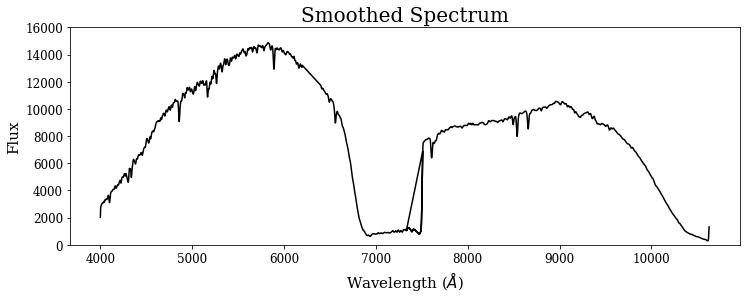

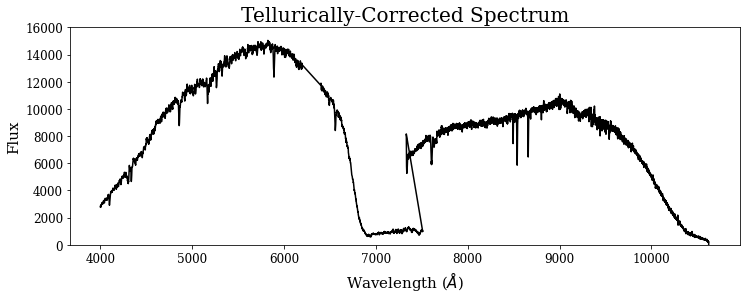

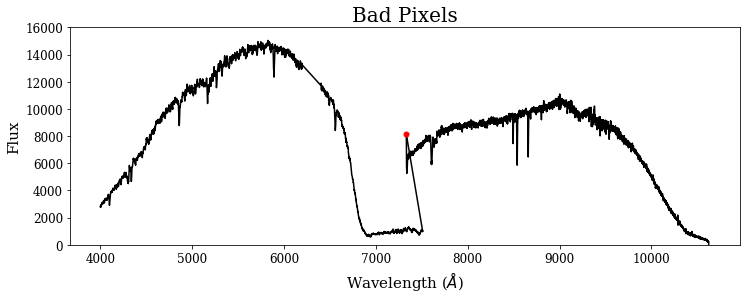

In [29]:
#Smooth spectrum and check interpolated regions - can adjust thresholds if needed
smooth_wave, smooth_flux, smooth_noise, smooth_bad, flux, res = smoothing(blue_path, red_path, tell_wave, tell_flux, 30000, 0, 20000, 8000)

#Inspect
plt.figure(figsize=(12, 4))
plt.title('Smoothed Spectrum', fontsize=20)
plt.plot(smooth_wave, smooth_flux, color='k')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Wavelength ($\AA$)', fontsize=15)
plt.ylabel('Flux', fontsize=15)
plt.ylim(-1, 16000)

plt.figure(figsize=(12,4))
plt.title('Tellurically-Corrected Spectrum', fontsize=20)
plt.plot(smooth_wave, flux, color='k')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Wavelength ($\AA$)', fontsize=15)
plt.ylabel('Flux', fontsize=15)
plt.ylim(0, 16000)

plt.figure(figsize=(12,4))
plt.title('Bad Pixels', fontsize=20)
plt.plot(smooth_wave, flux, color='k')
plt.plot(smooth_wave[smooth_bad], flux[smooth_bad],  linestyle='None', marker='.', markersize=10, color='r')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Wavelength ($\AA$)', fontsize=15)
plt.ylabel('Flux', fontsize=15)
plt.ylim(0, 16000)

In [32]:
#Make a column of ones for the weight
weight_col = np.ones(len(smooth_wave))

#Write data to file.  I remove the column names (0 1 2 3 4) and add the wavelength chunk definitions in manually afterward.
#Have been meaning to re-write this to automatically write the wavelength chunks, will do at some point.
df = pd.DataFrame(np.array((smooth_wave, smooth_flux, smooth_noise, weight_col, res)).T)
#df.to_csv('B058_new_unfluxed_no6300.dat', index=False, sep='\t')
df

,0,1,2,3,4
0,4001.217541,2030.966139,33.816816,1.0,217.675819
1,4002.604083,2510.539878,38.498543,1.0,217.619847
2,4003.988391,2698.498982,40.411866,1.0,217.564005
3,4005.371977,2790.868853,41.344200,1.0,217.508230
4,4006.757839,2837.646690,41.769149,1.0,217.452402
...,...,...,...,...,...
6358,10621.528562,424.872484,21.241321,1.0,56.327859
6359,10622.327437,463.261328,21.398274,1.0,56.353916
6360,10623.123788,540.115586,21.801818,1.0,56.379914
6361,10623.922445,705.152638,22.793975,1.0,56.406011
